In [1]:
import pandas as pd

DATA_FILENAME = '/Users/gil-arnaudcoche/Documents/kurasutaku/data/5m/combined/1702198388323291/klines.csv'

data = pd.read_csv(DATA_FILENAME)
data['kline_open_time'] = pd.to_datetime(data['kline_open_time'], unit='ms')
data.set_index('kline_open_time', inplace=True)
data

symbol  open_price  high_price  low_price  \
kline_open_time                                                     
2023-11-01 00:00:00  CYBERUSDT      7.1220      7.1870     7.0280   
2023-11-01 00:05:00  CYBERUSDT      7.0550      7.1160     7.0490   
2023-11-01 00:10:00  CYBERUSDT      7.0500      7.0590     6.9500   
2023-11-01 00:15:00  CYBERUSDT      6.9990      7.0380     6.9880   
2023-11-01 00:20:00  CYBERUSDT      7.0390      7.0450     6.9410   
...                        ...         ...         ...        ...   
2023-11-30 23:35:00   TUSDUSDT      0.9984      0.9984     0.9983   
2023-11-30 23:40:00   TUSDUSDT      0.9983      0.9984     0.9983   
2023-11-30 23:45:00   TUSDUSDT      0.9984      0.9984     0.9983   
2023-11-30 23:50:00   TUSDUSDT      0.9984      0.9984     0.9983   
2023-11-30 23:55:00   TUSDUSDT      0.9984      0.9984     0.9983   

                     close_price    volume  kline_close_time  \
kline_open_time                                                
2023-11-01 00:00:00       7.0510  40675.18     1698797099999   
2023-11-01 00:05:00       7.0500  32474.22     1698797399999   
2023-11-01 00:10:00       6.9940  66693.27     1698797699999   
2023-11-01 00:15:00       7.0370  21393.35     1698797999999   
2023-11-01 00:20:00       6.9610  25332.75     1698798299999   
...                          ...       ...               ...   
2023-11-30 23:35:00       0.9984  14402.00     1701387599999   
2023-11-30 23:40:00       0.9984  10540.00     1701387899999   
2023-11-30 23:45:00       0.9984  11543.00     1701388199999   
2023-11-30 23:50:00       0.9984  25105.00     1701388499999   
2023-11-30 23:55:00       0.9984   5680.00     1701388799999   

                     quote_asset_volume  number_of_trades  \
kline_open_time                                             
2023-11-01 00:00:00        288448.76409              1256   
2023-11-01 00:05:00        230018.28716               777   
2023-11-01 00:10:00        466989.73479              1727   
2023-11-01 00:15:00        150015.50639               780   
2023-11-01 00:20:00        176815.13289               931   
...                                 ...               ...   
2023-11-30 23:35:00         14378.60120                74   
2023-11-30 23:40:00         10522.84420                32   
2023-11-30 23:45:00         11524.46310                51   
2023-11-30 23:50:00         25062.66270                41   
2023-11-30 23:55:00          5670.85940                24   

                     taker_buy_base_asset_volume  taker_buy_quote_asset_volume  
kline_open_time                                                                 
2023-11-01 00:00:00                      9850.36                   69834.50957  
2023-11-01 00:05:00                     20795.61                  147422.15621  
2023-11-01 00:10:00                     15660.55                  109690.50672  
2023-11-01 00:15:00                     11464.56                   80396.76019  
2023-11-01 00:20:00                      9125.30                   63691.15089  
...                                          ...                           ...  
2023-11-30 23:35:00                     10846.00                   10828.64640  
2023-11-30 23:40:00                      7622.00                    7609.80480  
2023-11-30 23:45:00                     10862.00                   10844.62080  
2023-11-30 23:50:00                      3412.00                    3406.54080  
2023-11-30 23:55:00                      5154.00                    5145.75360  

[1624320 rows x 11 columns]

In [2]:
number_of_trades = data.pivot_table(values='number_of_trades', index='kline_open_time', columns='symbol').fillna(value=0)
prices = data.pivot_table(values='close_price', index='kline_open_time', columns='symbol').fillna(value=0)

import numpy as np

returns = np.log(prices/prices.shift(1))

import matplotlib.pyplot as plt

# Assuming 'prices' and 'returns' are already defined as per your previous code
C = returns.corr()
C1 = C.copy()
# Ensure C is symmetric
C = (C + C.T) / 2

symbols = C.columns

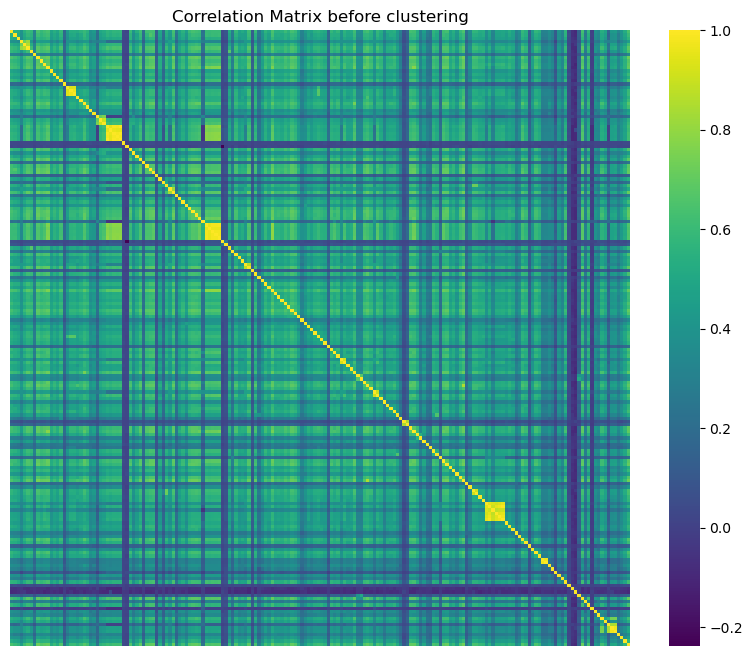

In [3]:
import numpy as np

eigen_values, eigen_vectors = np.linalg.eig(C)
eigen_values = np.real(eigen_values)
eigen_vectors = np.real(eigen_vectors)
idx = eigen_values.argsort()[::-1]
eigen_values = eigen_values[idx]
eigen_vectors = eigen_vectors[:,idx]
symbols = symbols[idx]

import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(C, cmap='viridis', annot=False)
plt.xlabel('')
plt.ylabel('')
plt.xticks([], [])
plt.yticks([], [])
plt.title('Correlation Matrix before clustering')
plt.show()


In [4]:
import pandas as pd
import numpy as np
from scipy.sparse.csgraph import minimum_spanning_tree
import networkx as nx


def create_mst_graph(C, cutoff):
    """
    Creates a graph representing the minimum spanning tree from a correlation matrix with a given cutoff.

    Parameters:
    C (pd.DataFrame): Correlation matrix.
    cutoff (float): Cutoff value for edge weights.

    Returns:
    networkx.Graph: The graph object representing the minimum spanning tree.
    """
    columns = C.columns
    # Convert to distance matrix
    distance_matrix = 1 - np.abs(C.values)

    # Compute the minimum spanning tree
    mst = minimum_spanning_tree(distance_matrix)

    # Create a NetworkX graph
    G = nx.Graph()

    # Add edges and weights to the graph, applying the cutoff
    for i, j in zip(*mst.nonzero()):
        weight = 1 - mst[i, j]
        if weight > cutoff:
            G.add_edge(columns[i], columns[j], weight=weight)

    return G


import matplotlib.pyplot as plt

def plot_graph(G, title):
    """
    Plots a given graph.

    Parameters:
    G (networkx.Graph): The graph to be plotted.
    title (str): Title for the plot.
    """
    # Use the Kamada-Kawai layout for positioning
    pos = nx.spring_layout(G, seed=0, iterations=40)

    # Draw the graph
    plt.figure(figsize=(30, 30))
    nx.draw(G, pos, with_labels=True, node_color='pink', node_size=2500, edge_color='gray', linewidths=1, font_size=25, alpha=.7)

    # Display edge weights
    edge_labels = nx.get_edge_attributes(G, 'weight')
    edge_labels = {e: round(w, 2) for e, w in edge_labels.items()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title(title, fontsize=40)
    plt.show()

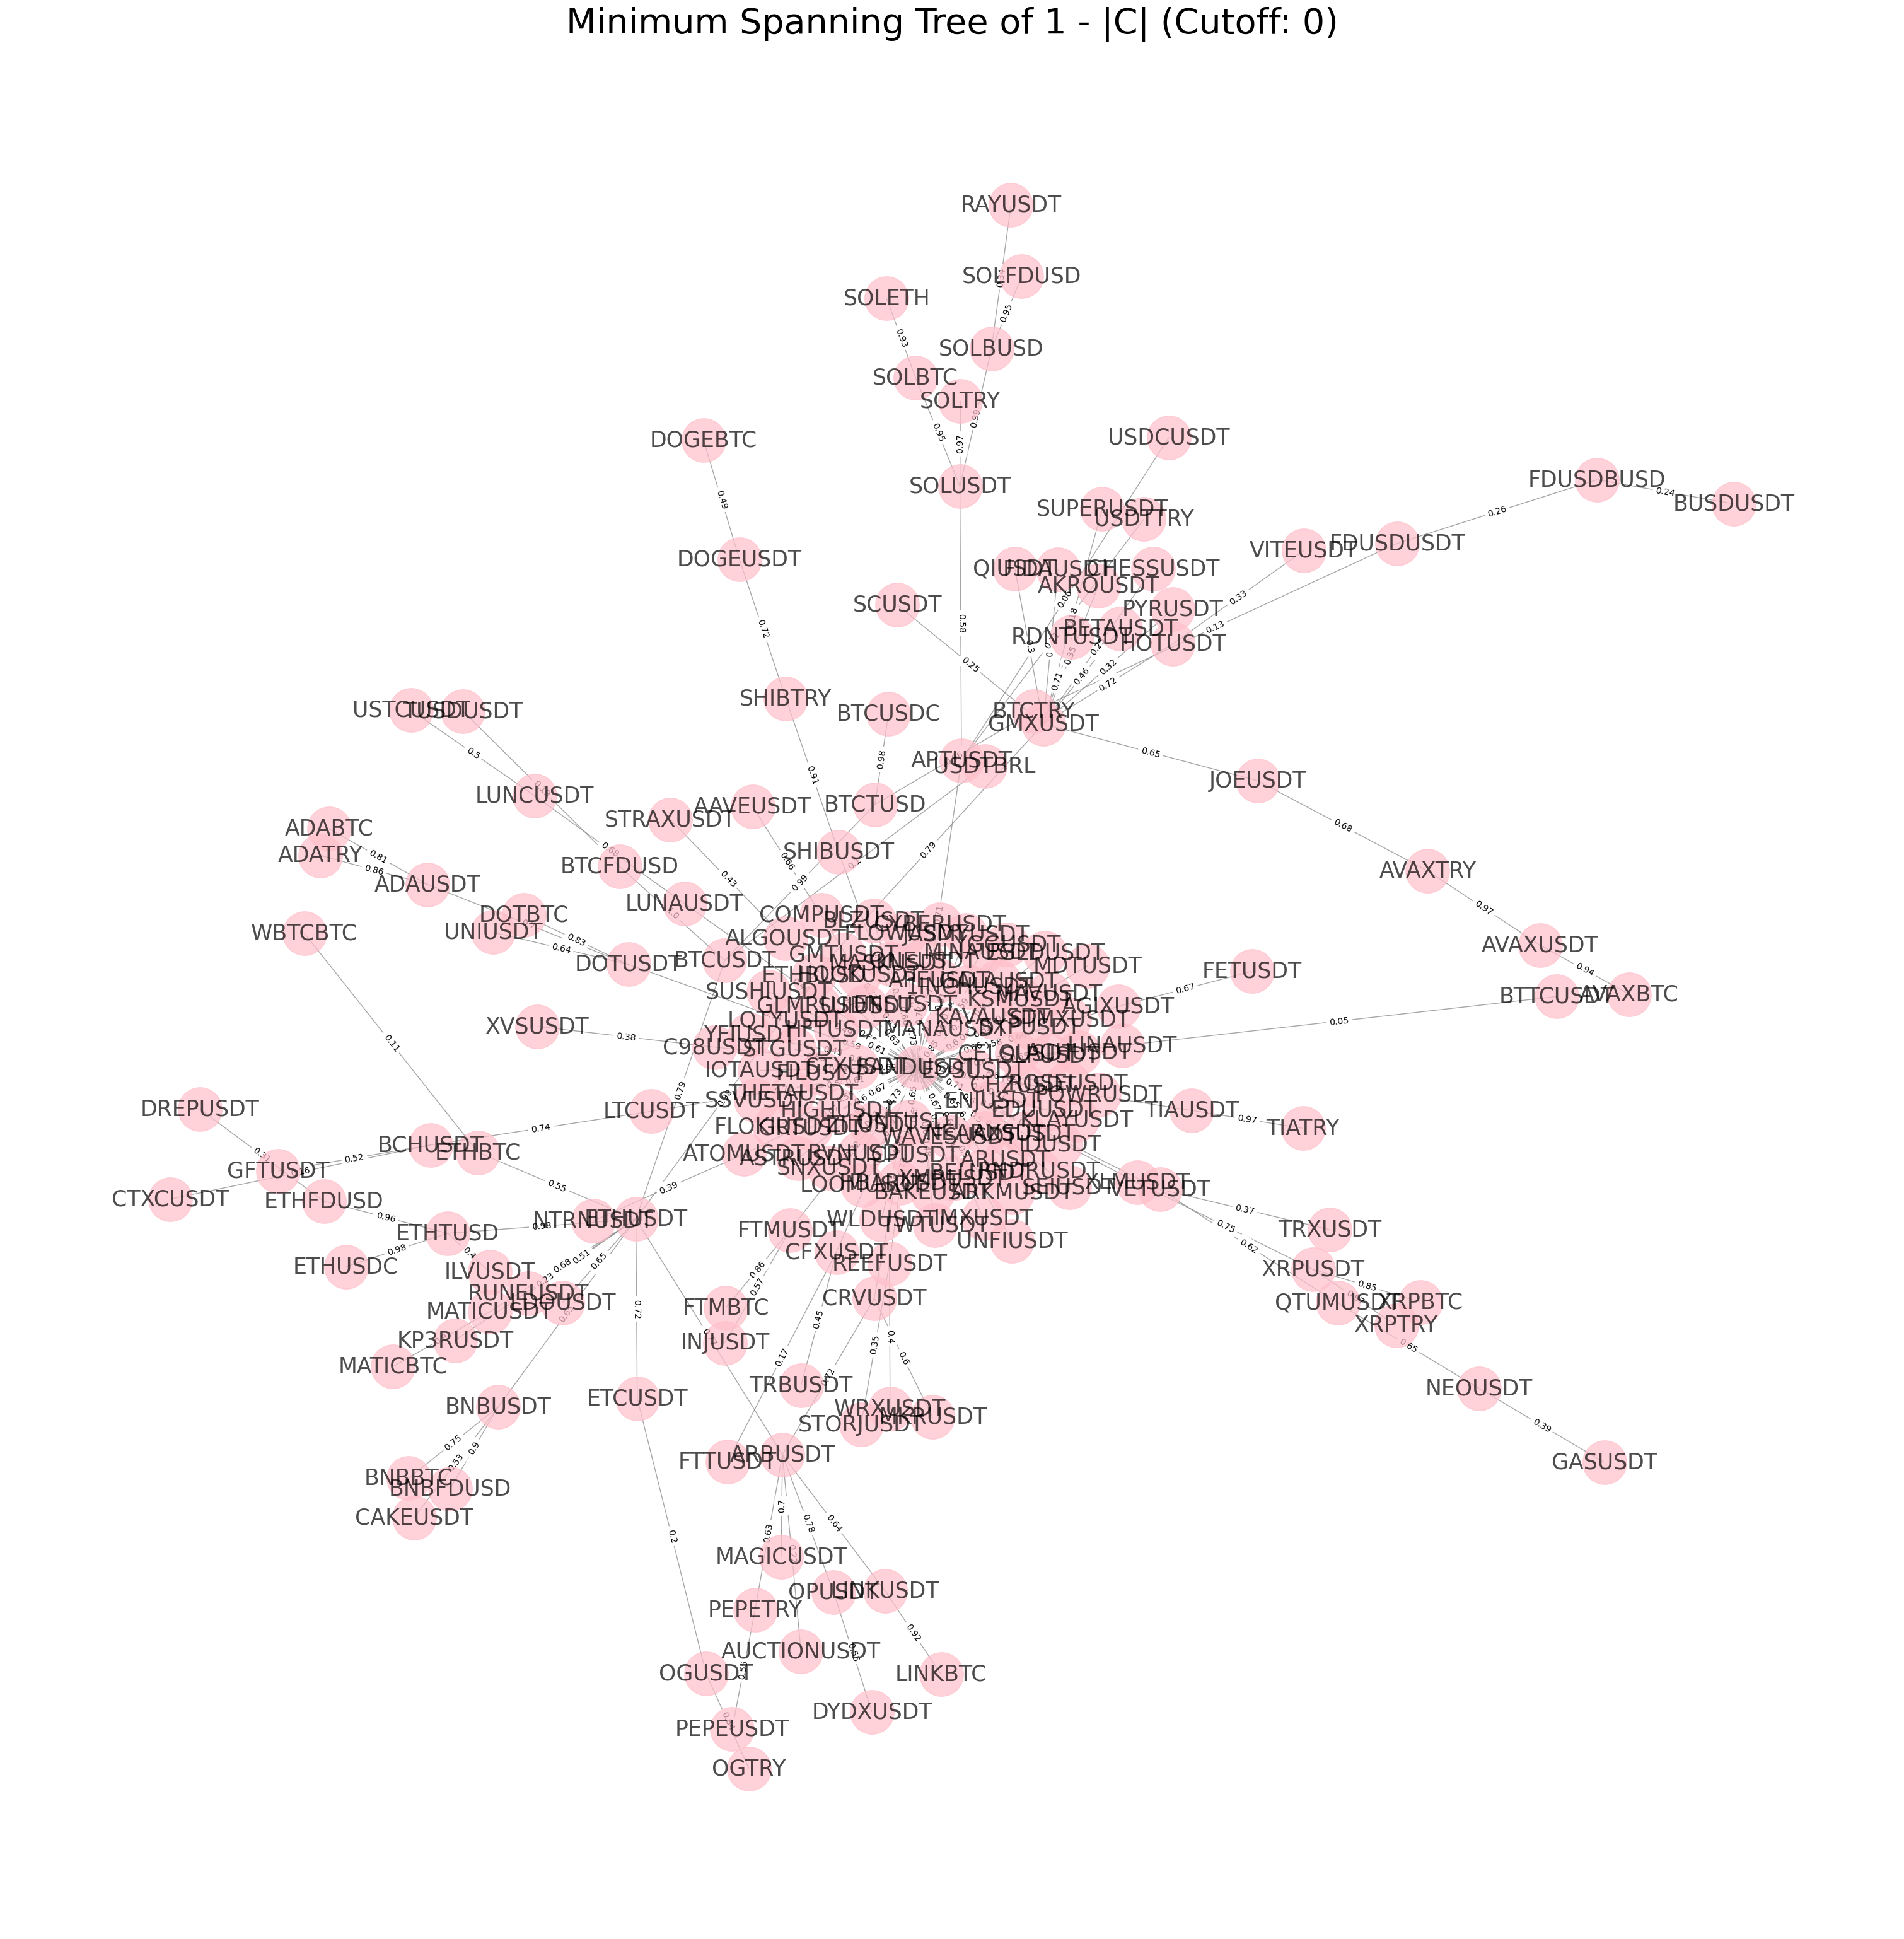

In [5]:
cutoff = 0
G = create_mst_graph(C, cutoff=cutoff)
plot_graph(G, f"Minimum Spanning Tree of 1 - |C| (Cutoff: {cutoff})")

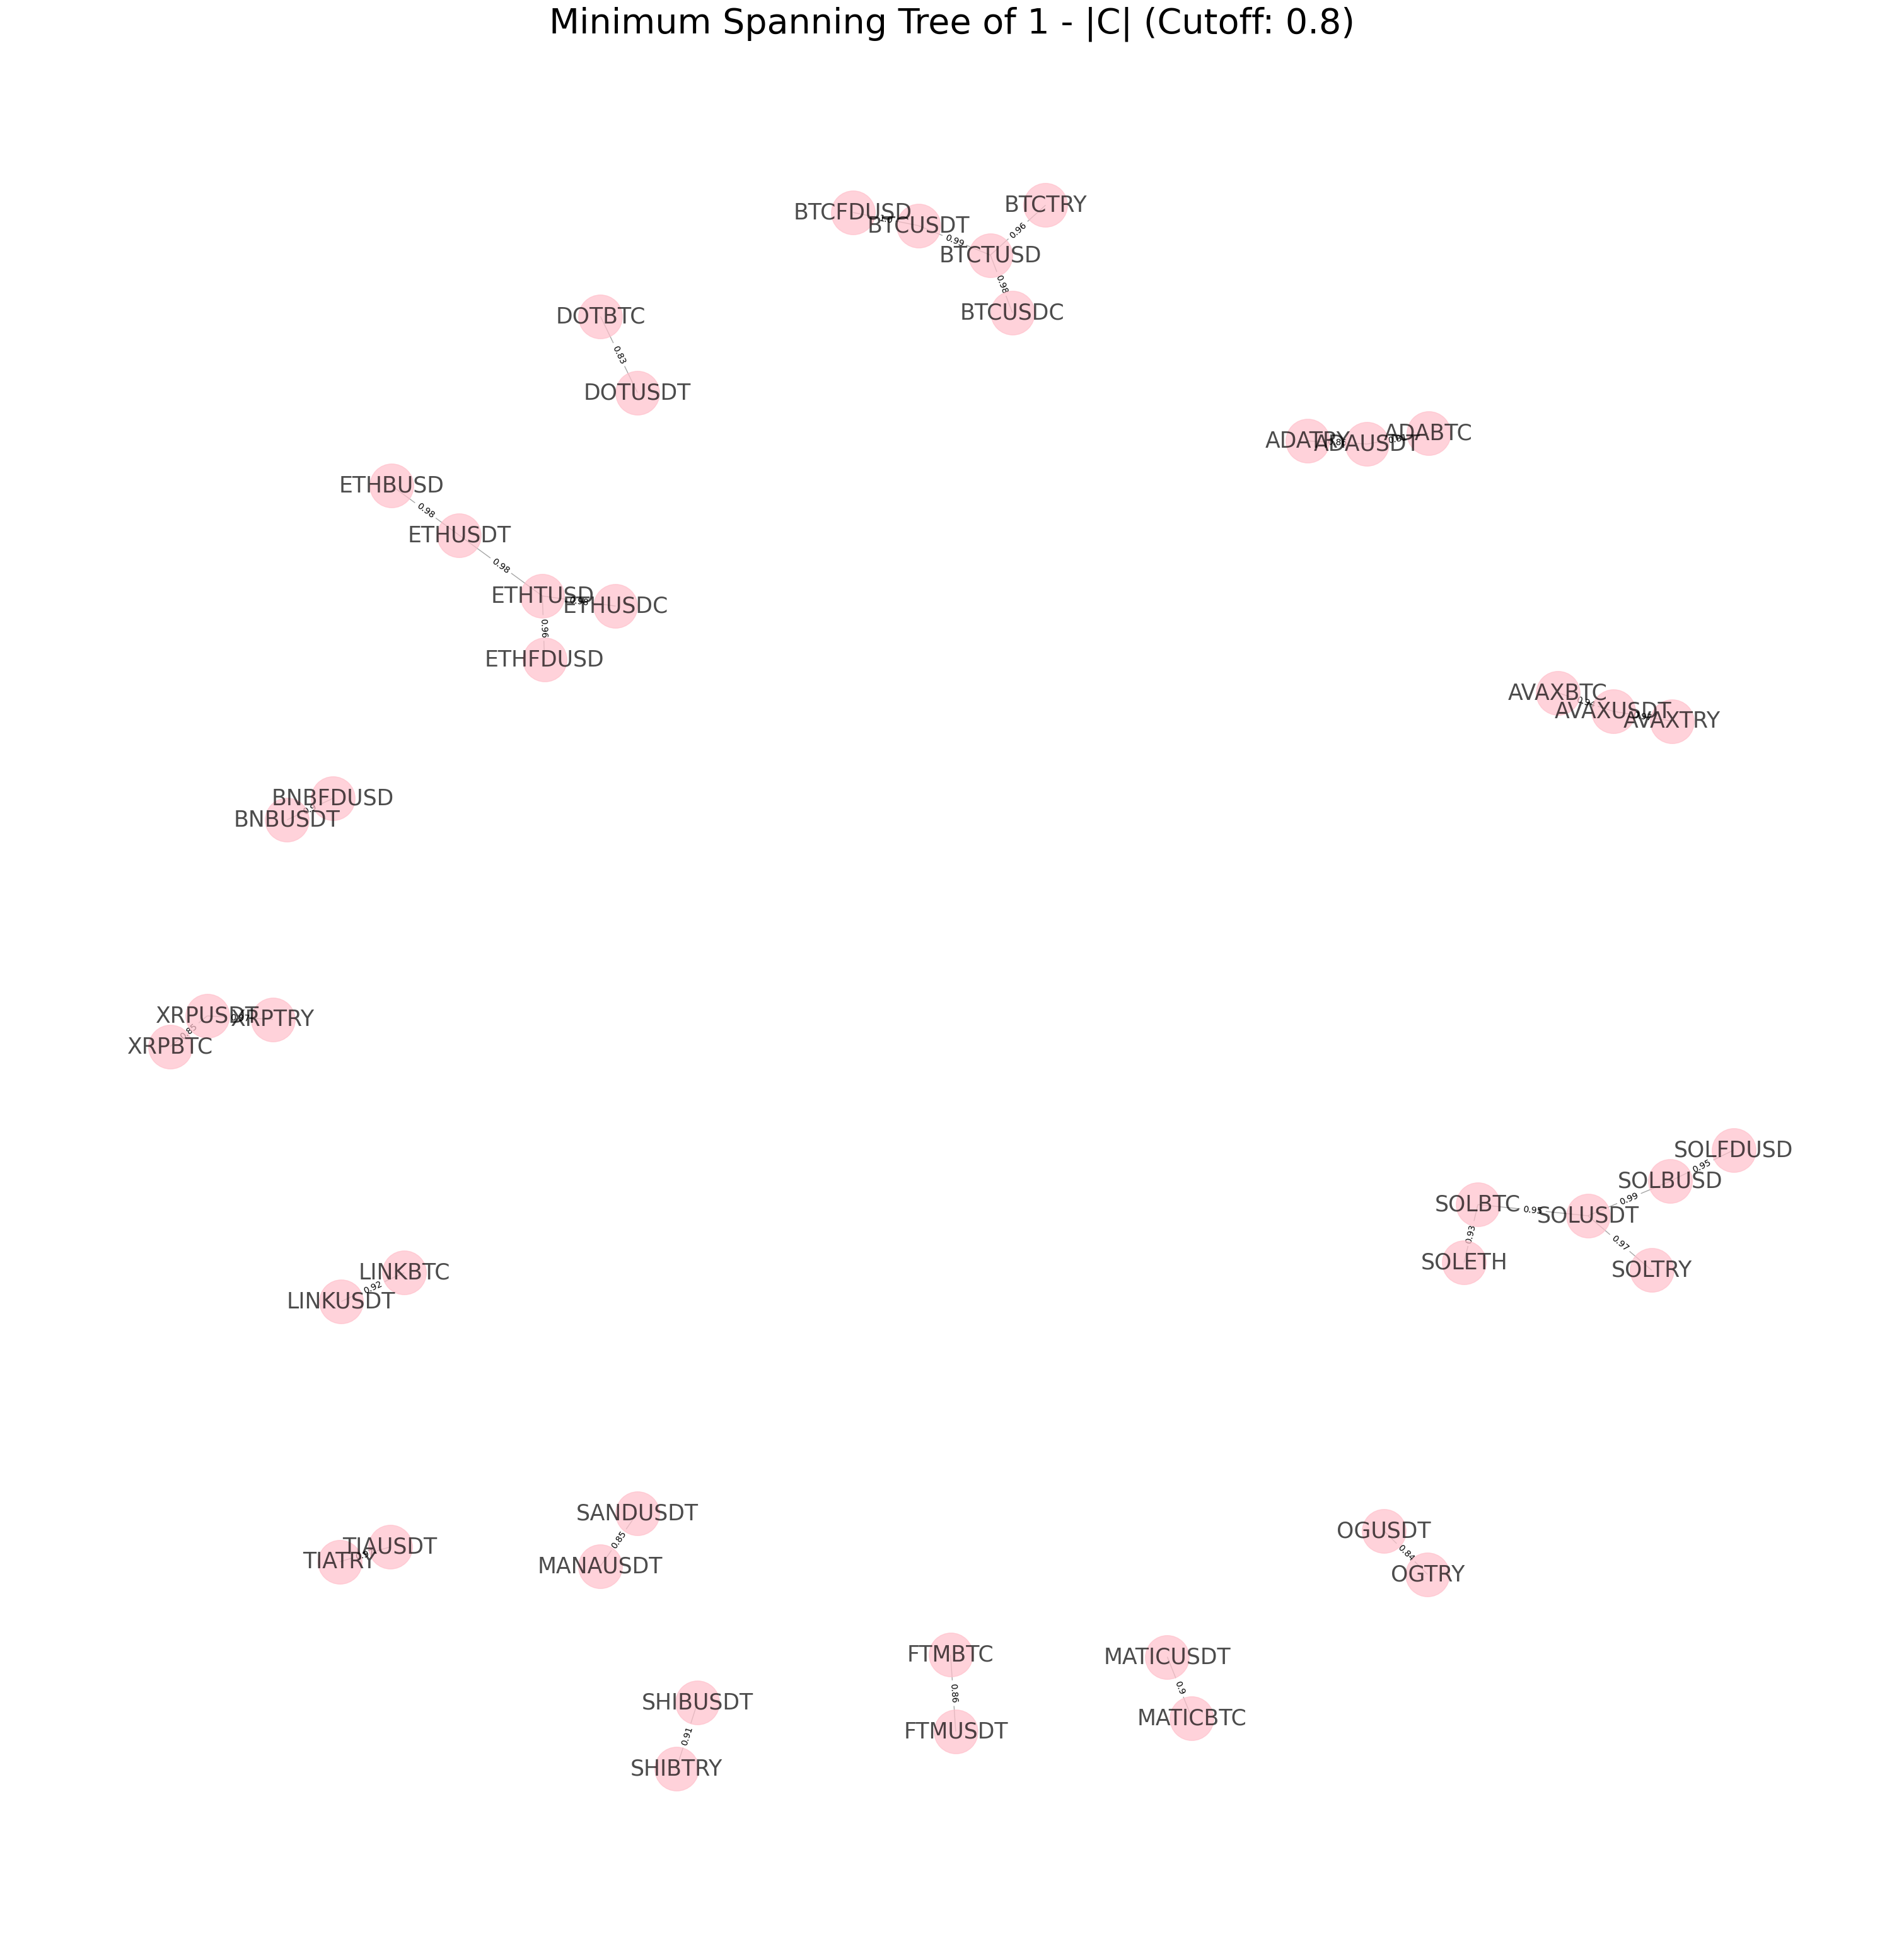

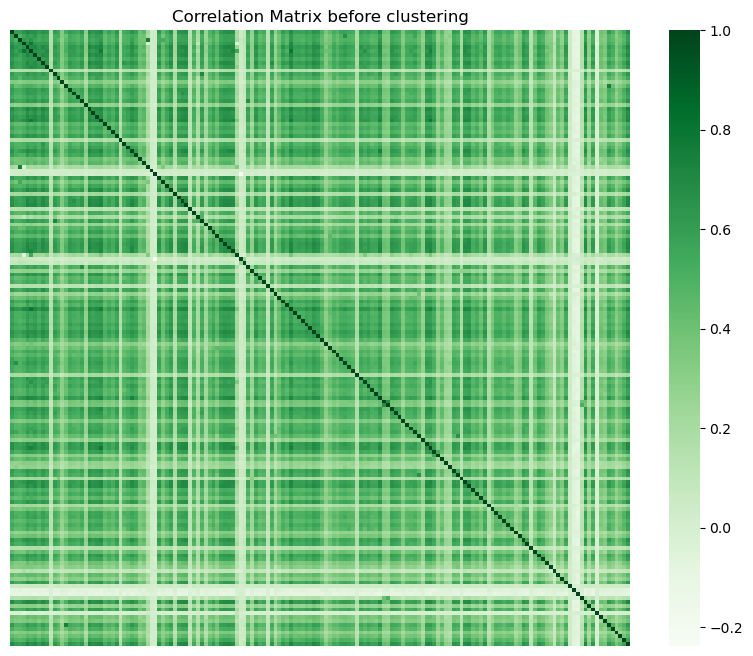

In [6]:
cutoff = .8
G = create_mst_graph(C, cutoff=cutoff)
plot_graph(G, f"Minimum Spanning Tree of 1 - |C| (Cutoff: {cutoff})")
clusters = list(nx.connected_components(G))
representatives = []
for cluster in clusters:
    # Sort nodes to favor 'USDT' in names
    sorted_cluster = sorted(list(cluster), key=lambda x: 'USDT' not in x)
    representatives.append(sorted_cluster[0])
excluded_symbols = set()
for cluster in clusters:
    for symbol in cluster:
        excluded_symbols.add(symbol)
symbols = representatives + [ symbol for symbol in C.columns if not symbol in excluded_symbols ]
C = C.loc[symbols, symbols]

plt.figure(figsize=(10, 8))
sns.heatmap(C, cmap='Greens', annot=False)
plt.xlabel('')
plt.ylabel('')
plt.xticks([], [])
plt.yticks([], [])
plt.title(f'Correlation Matrix after clustering (Cutoff: {cutoff})')
plt.show()


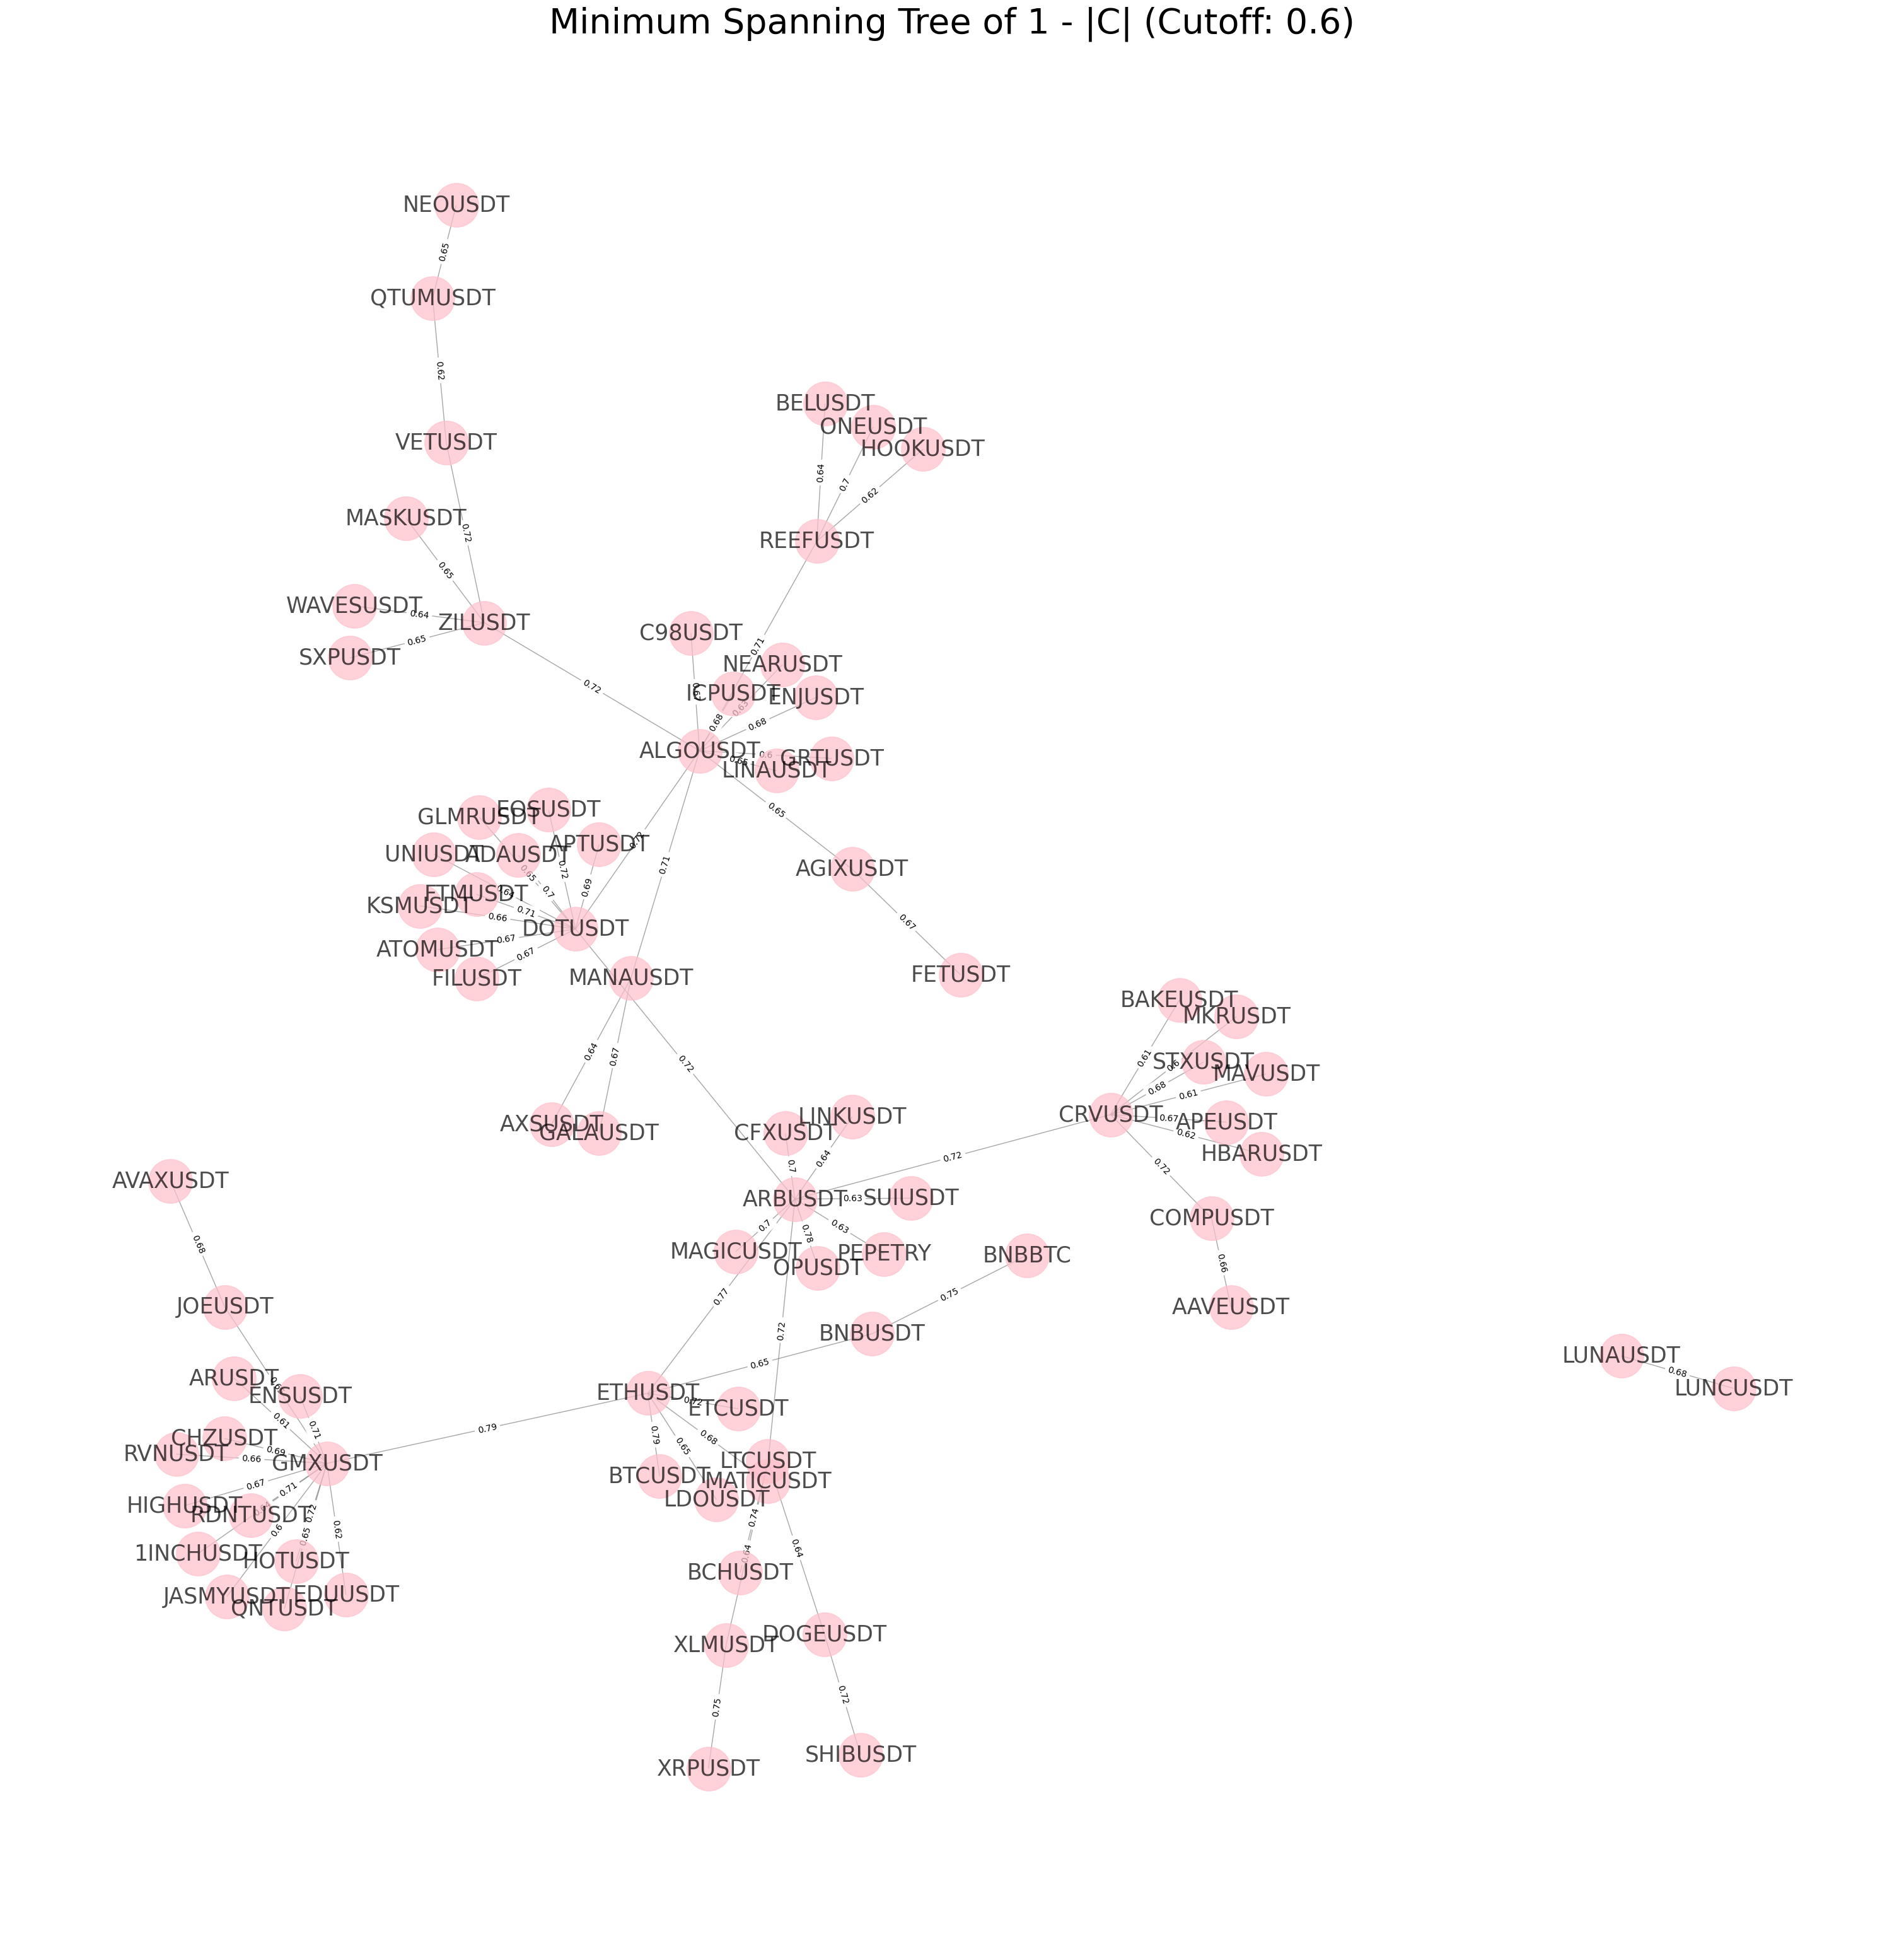

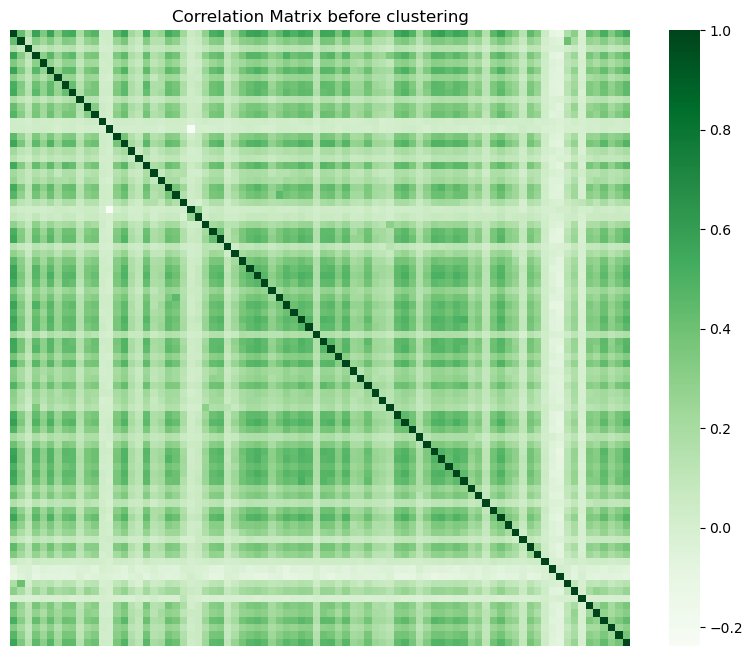

In [7]:
cutoff = .6
G = create_mst_graph(C, cutoff=cutoff)
plot_graph(G, f"Minimum Spanning Tree of 1 - |C| (Cutoff: {cutoff})")
clusters = list(nx.connected_components(G))
representatives = []
for cluster in clusters:
    # Sort nodes to favor 'USDT' in names
    sorted_cluster = sorted(list(cluster), key=lambda x: 'USDT' not in x)
    representatives.append(sorted_cluster[0])
excluded_symbols = set()
for cluster in clusters:
    for symbol in cluster:
        excluded_symbols.add(symbol)
symbols = representatives + [ symbol for symbol in C.columns if not symbol in excluded_symbols ]
C = C.loc[symbols, symbols]

plt.figure(figsize=(10, 8))
sns.heatmap(C, cmap='Greens', annot=False)
plt.xlabel('')
plt.ylabel('')
plt.xticks([], [])
plt.yticks([], [])
plt.title(f'Correlation Matrix after clustering (Cutoff: {cutoff})')
plt.show()


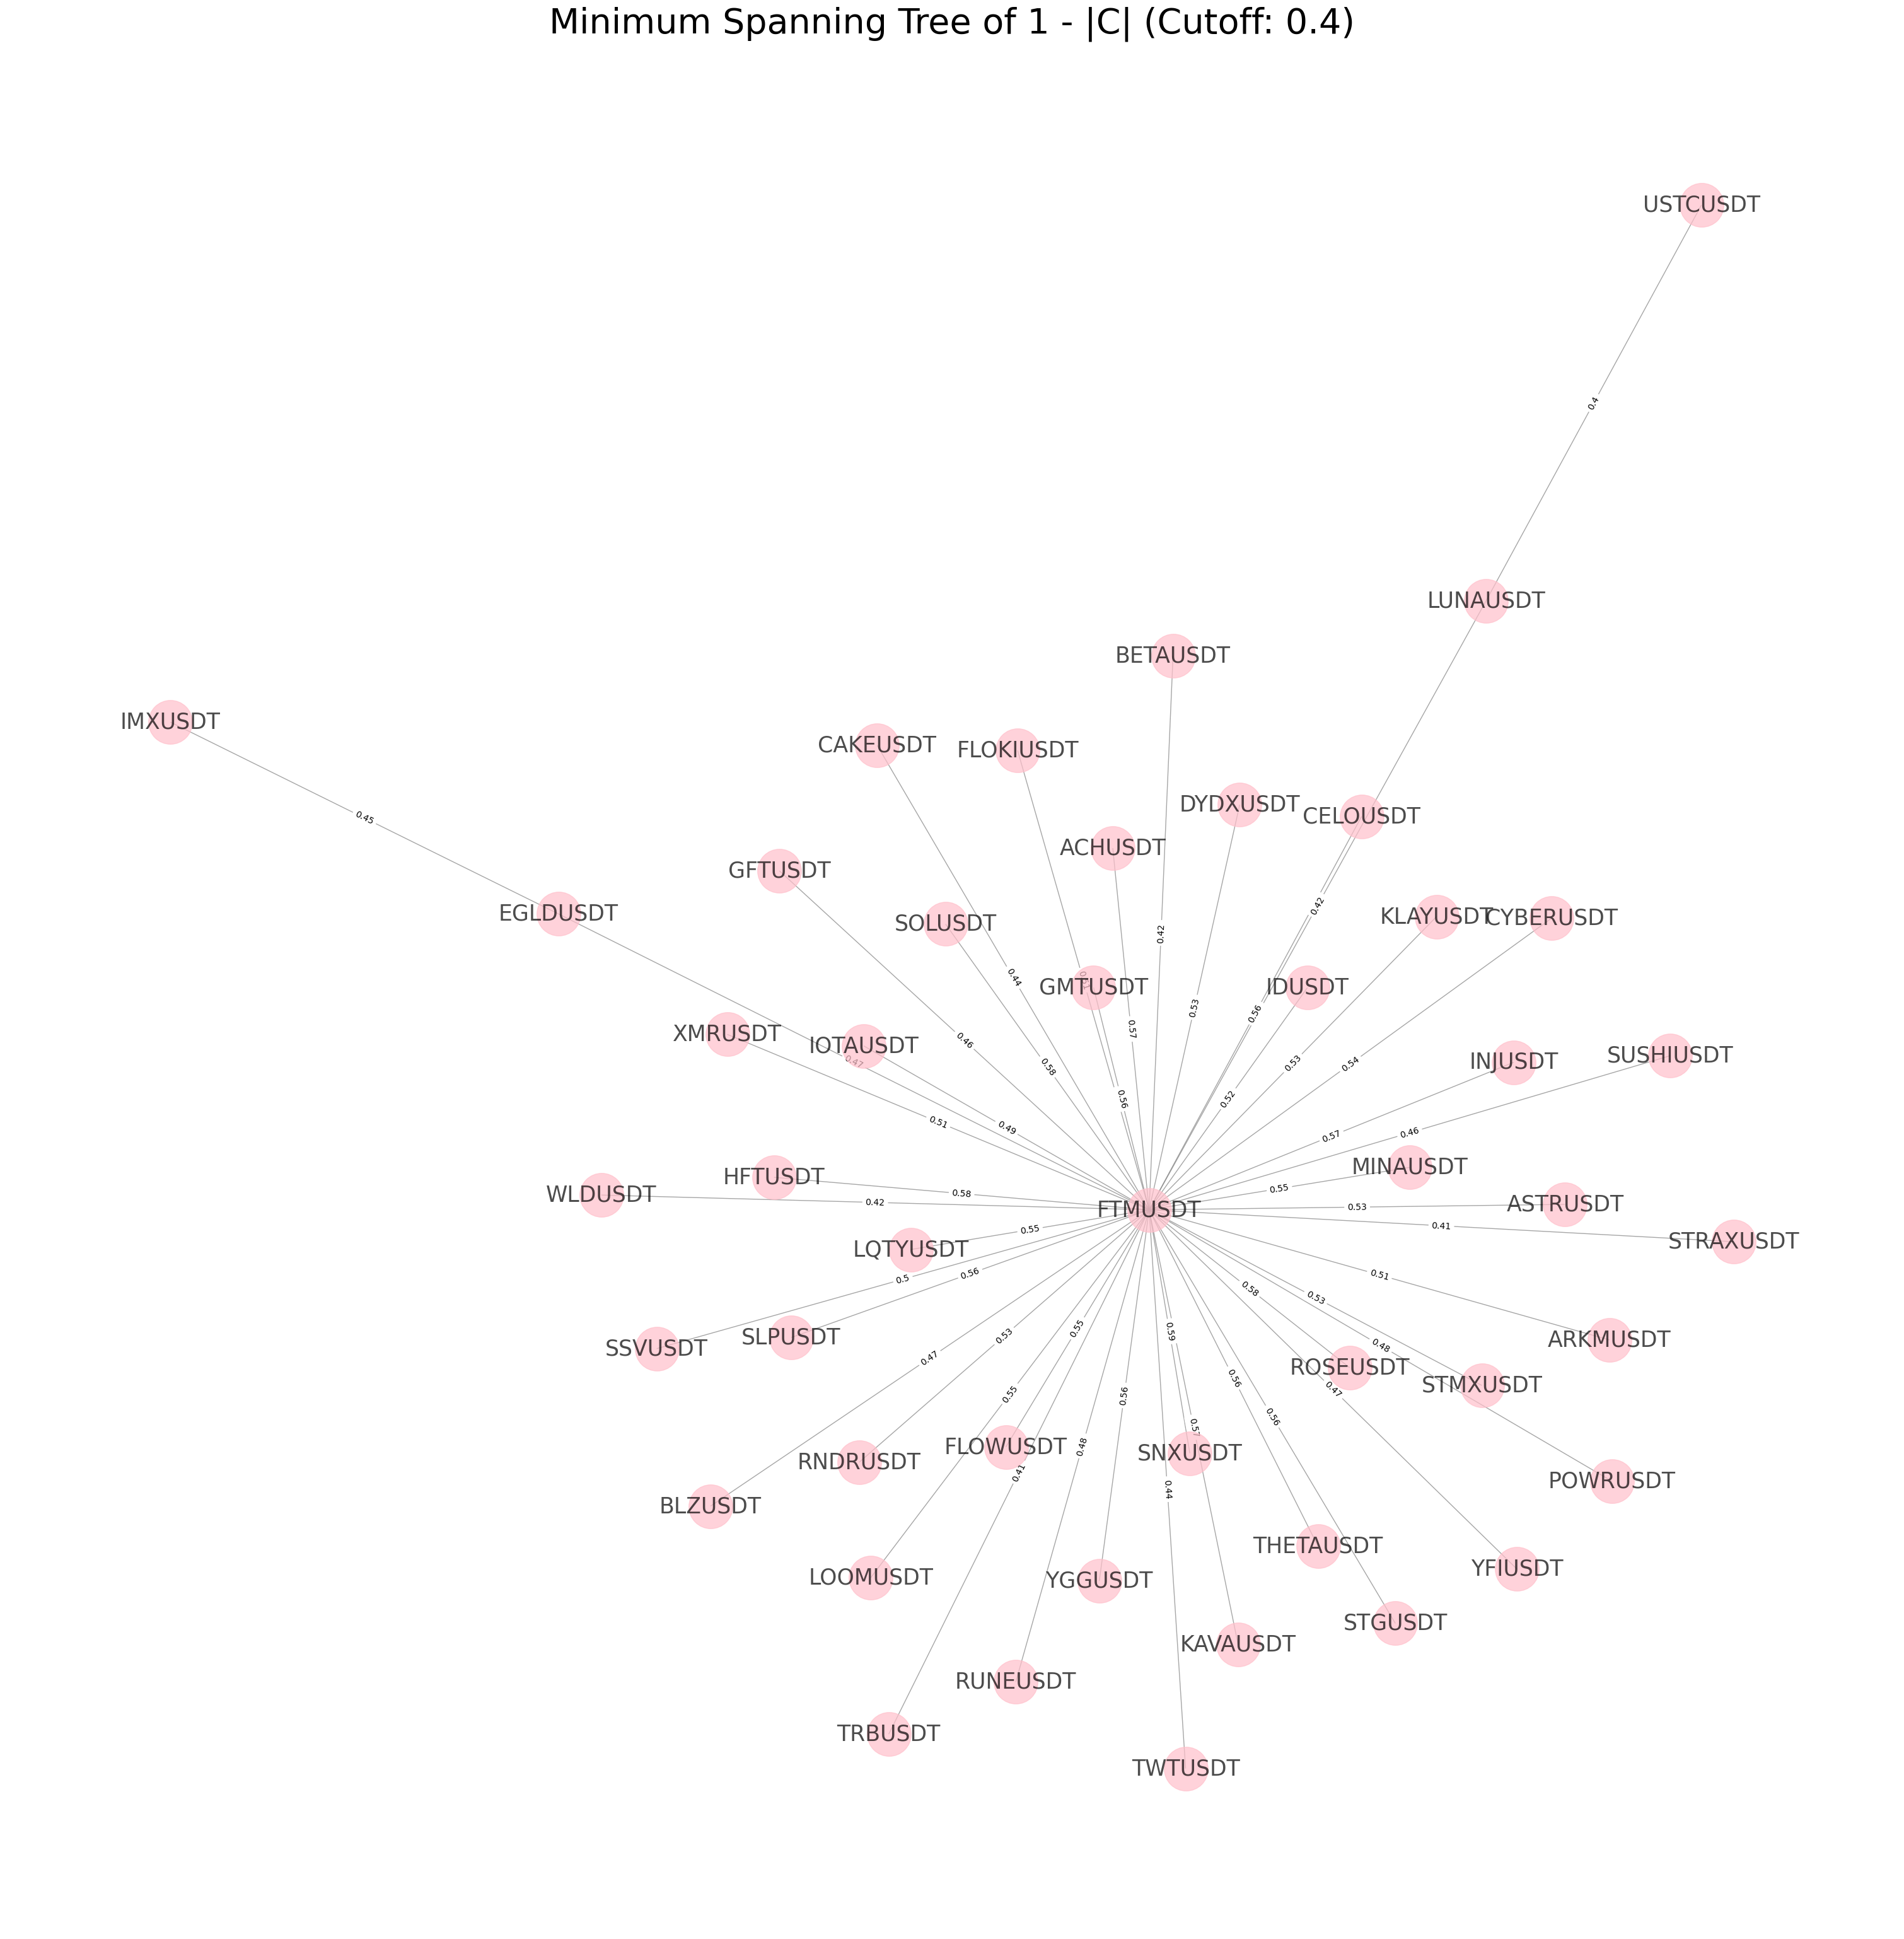

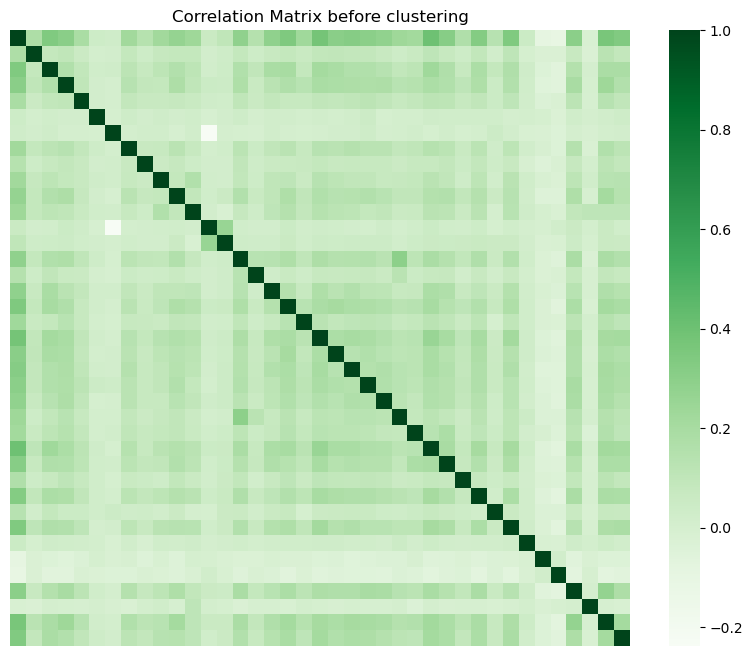

In [8]:
cutoff = .4
G = create_mst_graph(C, cutoff=cutoff)
plot_graph(G, f"Minimum Spanning Tree of 1 - |C| (Cutoff: {cutoff})")
clusters = list(nx.connected_components(G))
representatives = []
for cluster in clusters:
    # Sort nodes to favor 'USDT' in names
    sorted_cluster = sorted(list(cluster), key=lambda x: 'USDT' not in x)
    representatives.append(sorted_cluster[0])
excluded_symbols = set()
for cluster in clusters:
    for symbol in cluster:
        excluded_symbols.add(symbol)
symbols = representatives + [ symbol for symbol in C.columns if not symbol in excluded_symbols ]
C = C.loc[symbols, symbols]

plt.figure(figsize=(10, 8))
sns.heatmap(C, cmap='Greens', annot=False)
plt.xlabel('')
plt.ylabel('')
plt.xticks([], [])
plt.yticks([], [])
plt.title('Correlation Matrix before clustering')
plt.show()


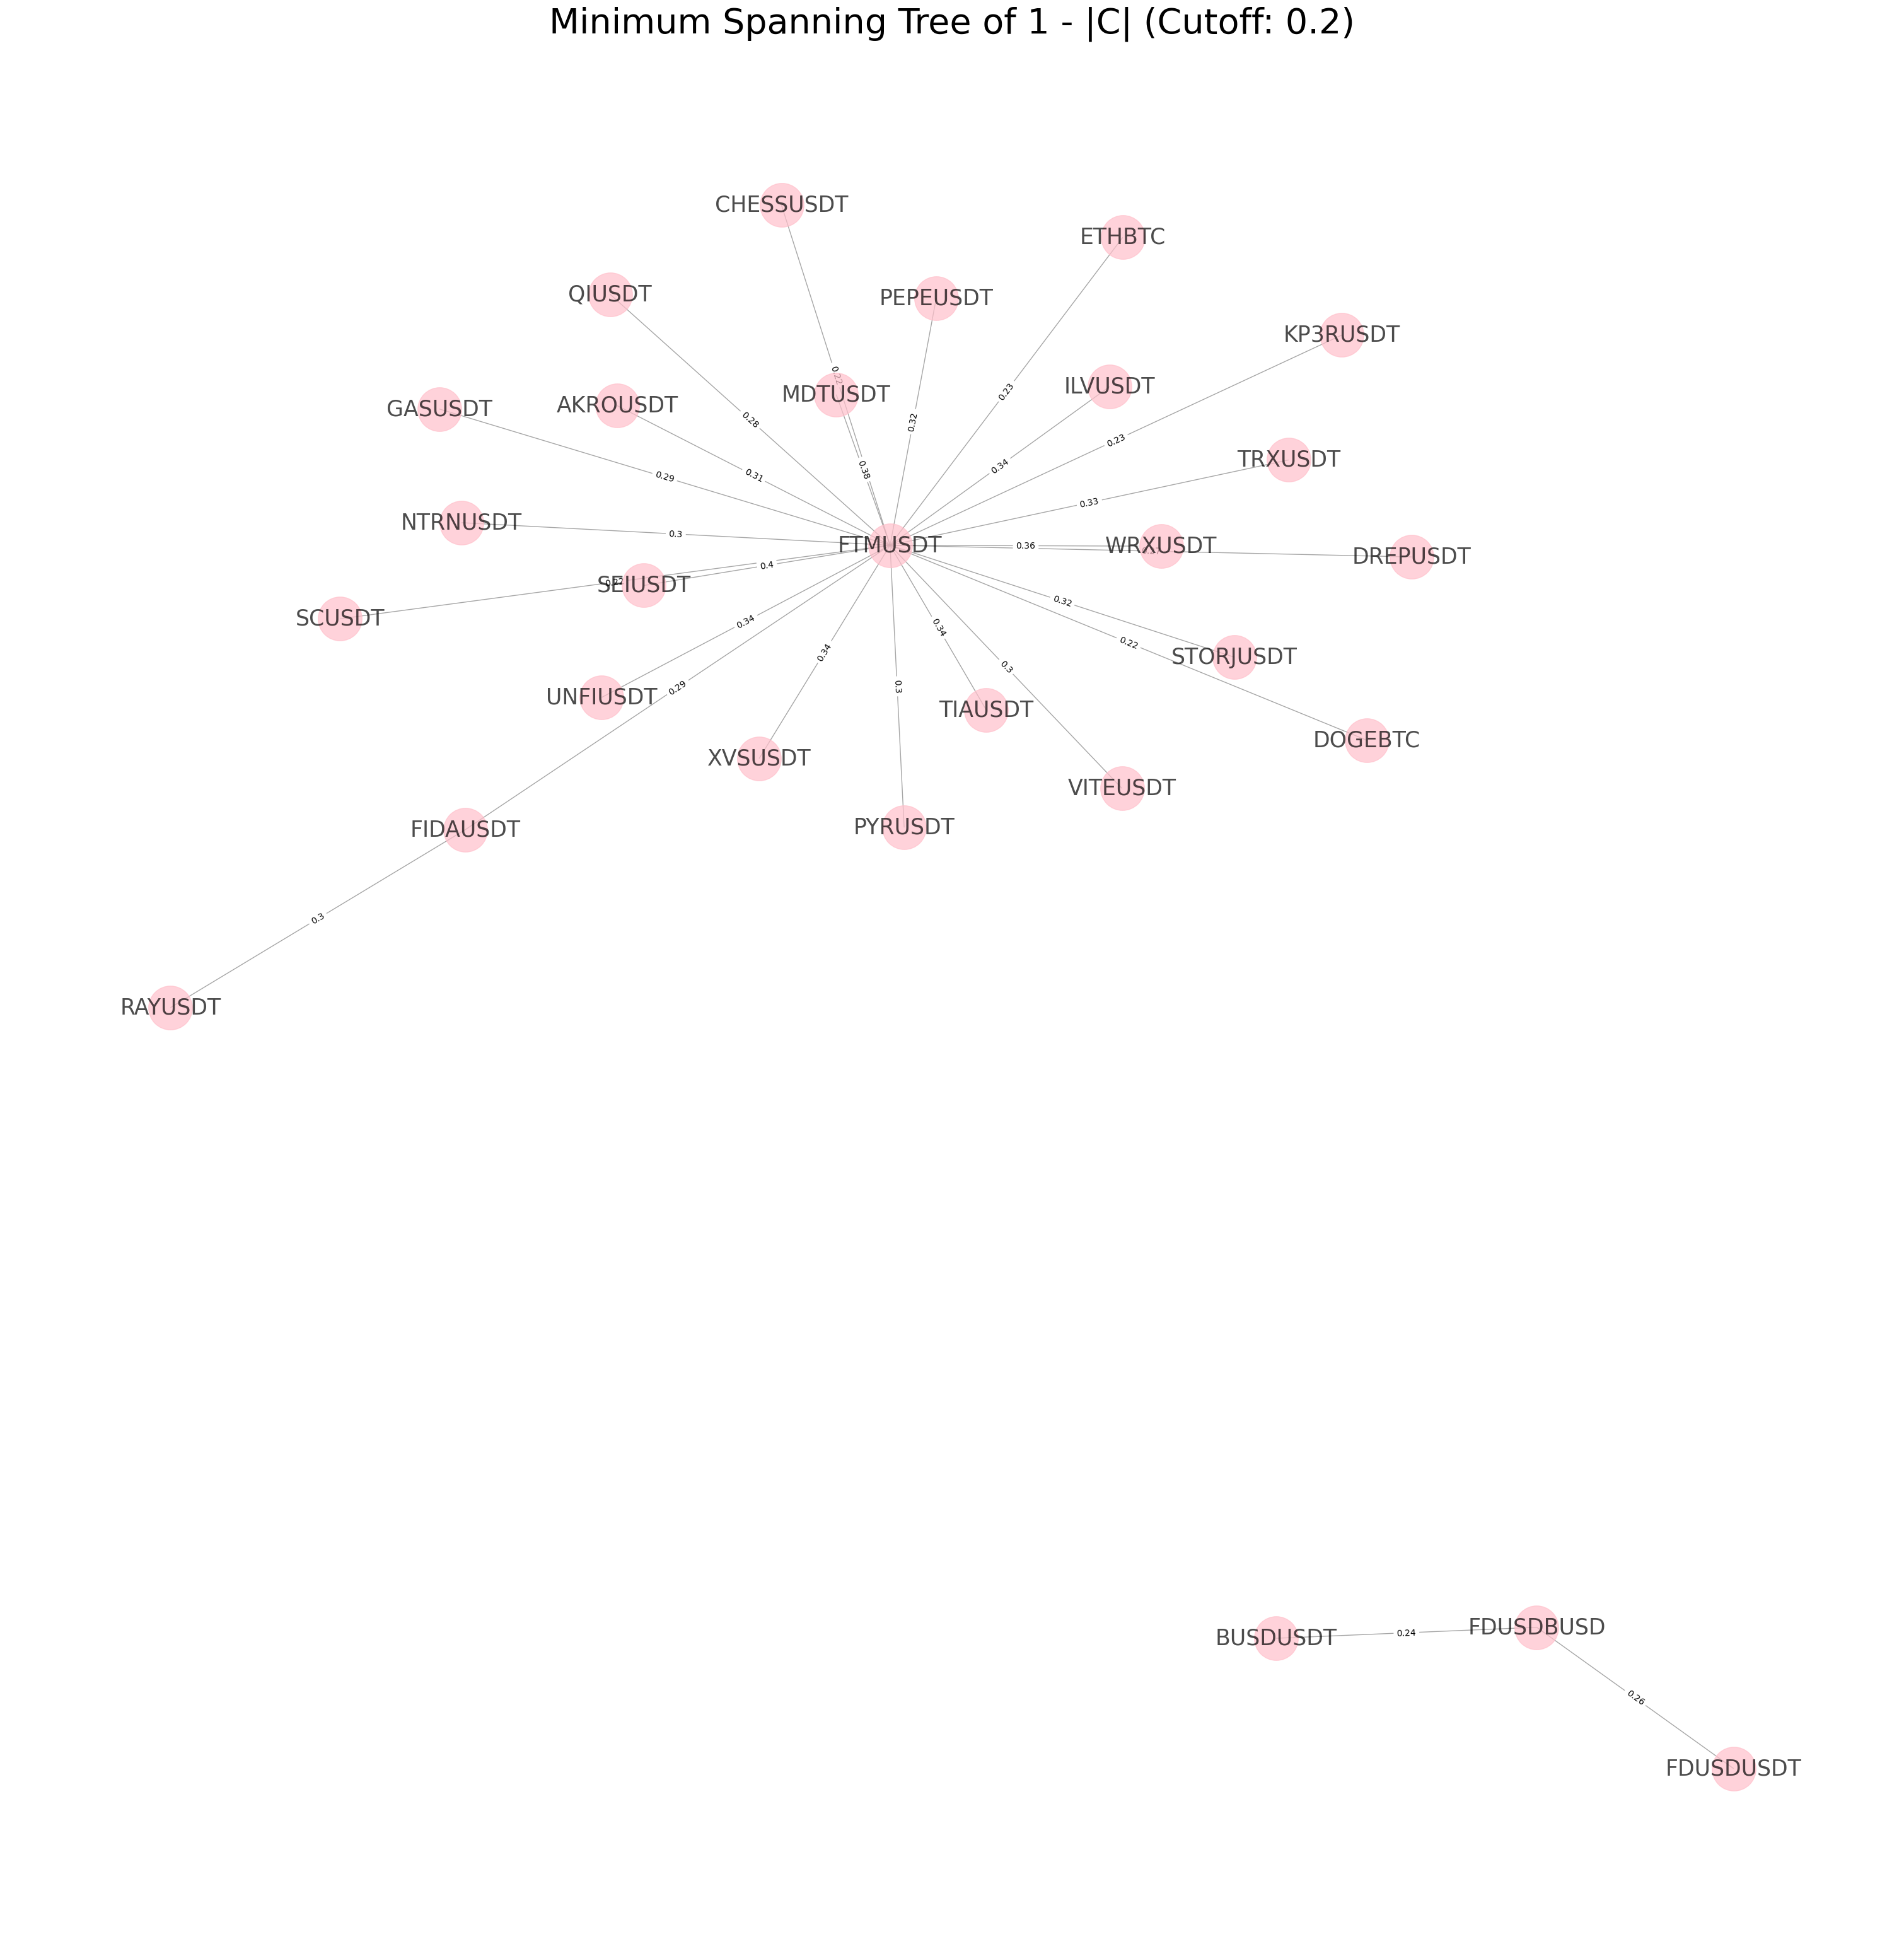

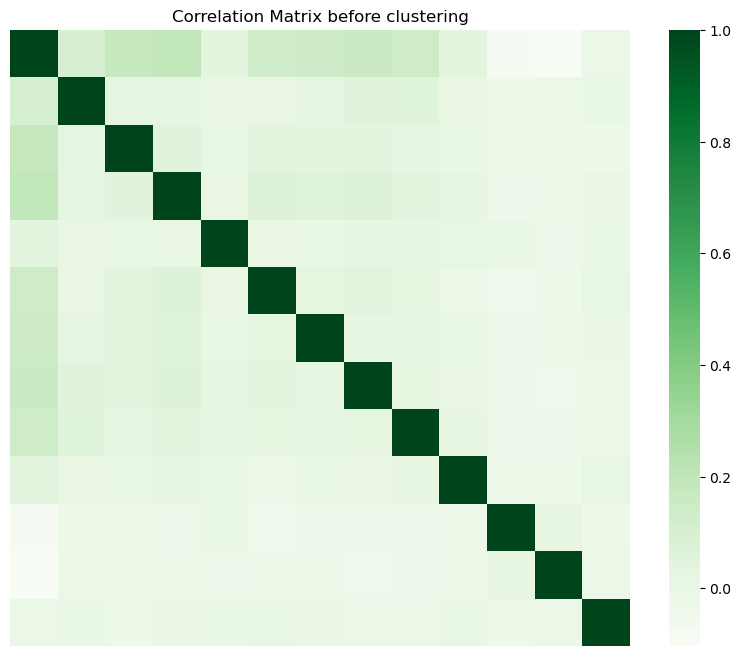

In [9]:
cutoff = .2
G = create_mst_graph(C, cutoff=cutoff)
plot_graph(G, f"Minimum Spanning Tree of 1 - |C| (Cutoff: {cutoff})")
clusters = list(nx.connected_components(G))
representatives = []
for cluster in clusters:
    # Sort nodes to favor 'USDT' in names
    sorted_cluster = sorted(list(cluster), key=lambda x: 'USDT' not in x)
    representatives.append(sorted_cluster[0])
excluded_symbols = set()
for cluster in clusters:
    for symbol in cluster:
        excluded_symbols.add(symbol)
symbols = representatives + [ symbol for symbol in C.columns if not symbol in excluded_symbols ]
C = C.loc[symbols, symbols]

plt.figure(figsize=(10, 8))
sns.heatmap(C, cmap='Greens', annot=False)
plt.xlabel('')
plt.ylabel('')
plt.xticks([], [])
plt.yticks([], [])
plt.title(f'Correlation Matrix after clustering (Cutoff: {cutoff})')
plt.show()
